In [ ]:
import polars as pl
import pandas as pd
import tqdm
import numpy as np


In [2]:
df = pl.read_csv('./oof_df.csv')

In [3]:
correlations_df = pl.read_csv('../data/row/correlations.csv')

In [4]:
labels = []
for idx, df_ in tqdm.tqdm(df.groupby('topic_id'), total = len(df.unique(subset=["topic_id"]))):
    topic_id = idx
    content_ids = df_['content_id'].to_numpy()
    isin_list = np.array(correlations_df.filter(pl.col("topic_id")==topic_id)['content_ids'].item().split(' '))
    label = np.isin(content_ids, isin_list)
    labels.extend(label)

100%|██████████| 12303/12303 [00:10<00:00, 1160.85it/s]


In [5]:
df = df.with_column(
    pl.Series('label', labels)
)

<ipython-input-5-8088ab0c7b57>:1: DeprecationWarning: `with_column` has been deprecated in favor of `with_columns`. This method will be removed in version 0.17.0
  df = df.with_column(


In [6]:
df.filter(pl.col("predictions_proba")>=0.99)

topic_id,content_id,topic_title,content_title,fold,predictions_proba,label
str,str,str,str,i64,f64,i64
"""t_002eec45174c...","""c_6062d2e46506...","""Quadrilateral ...","""Proof: Opposit...",0,0.995302,0
"""t_002eec45174c...","""c_3386a0af5cad...","""Quadrilateral ...","""Proof: Rhombus...",0,0.99217,1
"""t_002eec45174c...","""c_b44c206ad756...","""Quadrilateral ...","""Proof: Opposit...",0,0.992966,1
"""t_002eec45174c...","""c_29633da013a9...","""Quadrilateral ...","""Proof: Diagona...",0,0.99326,1
"""t_002eec45174c...","""c_7971ba5f03c4...","""Quadrilateral ...","""Quadrilateral ...",0,0.994212,1
"""t_00342d98cbde...","""c_207b49228710...","""Funções expone...","""Gráficos de fu...",0,0.999235,0
"""t_00342d98cbde...","""c_ffe91e49b7d9...","""Funções expone...","""Gráficos de cr...",0,0.994945,0
"""t_00342d98cbde...","""c_3707c1e4395c...","""Funções expone...","""Gráficos de cr...",0,0.995024,0
"""t_00342d98cbde...","""c_39a0d3b7ce62...","""Funções expone...","""Funções expone...",0,0.998495,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14de8a0ee0>,
      dtype=object)

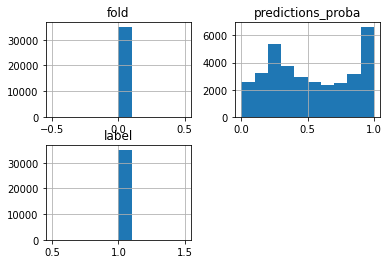

In [7]:
df.filter(pl.col("label")==1).to_pandas().hist()

In [8]:
df2 = pl.read_csv('/root/workspace/Learning_Equality/xlm-roberta-base/oof_df.csv')

In [30]:
def postprocess(df, threshold1: float=0.9, threshold2: float=0.9, top_n: int = 5):
    df.loc[:,'pred'] = 0 
    df.loc[(df.predictions_proba>=threshold1) | (df.predictions_proba_right>=threshold2), 'pred'] = 1
    result = []
    grouped_df = df.groupby('topic_id')
    for idx, df_ in tqdm.tqdm(grouped_df, total=len(grouped_df)):
        df_ = df_.sort_values('predictions_proba_right', ascending=False)
        if df_.pred.sum()==0:
            res_df = df_.iloc[:5]
        else:
            res_df = df_[df_.pred==1]
        result.append(res_df.loc[:,['topic_id', 'content_id']])
    result = pd.concat(result, axis=0)
    result = pd.DataFrame(result.groupby('topic_id').apply(lambda x:' '.join(x.content_id)))
    result =result.reset_index().rename(columns={0:'content_ids'})
    result['content_ids'] = result['content_ids'].apply(lambda x:' '.join(x.split(' ')))
    return result

In [13]:
df = df.join(df2, on=['topic_id', 'content_id'])

In [14]:
df = df.to_pandas().loc[:, ['topic_id', 'content_id', 'predictions_proba', 'predictions_proba_right']]

In [15]:
def calc_f2_score(true_ids, pred_ids):
  true_positives = len(set(true_ids)&set(pred_ids))
  false_positives = len(set(pred_ids)-set(true_ids))
  false_negatives = len(set(true_ids)-set(pred_ids))

  beta = 2
  f2_score = ((1+beta**2)*true_positives)/((1+beta**2)*true_positives + beta**2*false_negatives + false_positives)
  return f2_score

def calc_f2_score_mean(target_df, pred_df):
  shape = target_df.shape
  score = [calc_f2_score(target_df.loc[i, 'content_ids'].split(), pred_df.loc[i, 'content_ids'].split()) for i in range(shape[0])]
  target_df['f2_score'] = score
  return target_df['f2_score'].mean()

In [66]:
# correlations_df = correlations_df.to_pandas()
target_df = correlations_df[correlations_df.topic_id.isin(df.topic_id)].reset_index(drop=True)
result = postprocess(df, threshold1=0.97, threshold2 = 0.94, top_n = 3)
score = calc_f2_score_mean(target_df, result)

100%|██████████| 12303/12303 [00:14<00:00, 842.91it/s]


In [67]:
score

0.4164060119702079